- 내용 및 코드 참조 

  - 케라스 창시자로부터 배우는 딥러닝

  - 미술관에 GAN 딥러닝 실전 프로젝트 

# 적대적 생성 신경망(Generative Adversarial Networks, GAN)

- 2014년, Ian Goodfellow 소개

- VAE와는 다른 방법으로 이미지 잠재 공간을 학습

- 직관적으로 이해하는 방법

  - 가짜 피카소 그림을 그리는 위조범과 이를 판별하는 판매상의 관계

  - 위조품과 진짜 그림을 섞어서 판매상에게 보여주며  
    그림이 진짜인지 가짜인지 판매상은 판별하고 이를 위조범에게 피드백

  - 처음에는 형편없는 그림을 그리다가 점점 피카소의 스타일을 모방하게 되고  
    판매상은 위조품을 구분하는데 점점 더 전문가가 되어감

- GAN의 네트워크

  - 생성자 네트워크(generator network)

    - 랜덤 벡터(잠재 공간의 무작위한 포인트)를 입력으로 받아 이를 합성된 이미지로 디코딩

  - 판별자 네트워크(discriminator netowrk)

    - 이미지(실제 또는 가짜 이미지)를 입력으로 받아 훈련 세트에서 온 이미지인지 생성자가 만든 이미지인지 판별

- GAN은 최적화의 최솟값이 고정되어 있지 않음

  - 보통의 경사하강법은 **고정된 손실공간**에서 언덕을 내려오는 훈련 방법이지만  
    GAN은 매 단계가 조금씩 전체 공간을 바꾸기 때문에 최적화 과정이 최솟값을 찾는 것이 어려움

  - 두 힘간의 평형점을 찾는 시스템

  - 따라서, 학습과정이 매우 어려움  
    즉, 적절한 파라미터를 찾고 조정해야함
  
  <img src="https://paperswithcode.com/media/methods/gan.jpeg">

  <sub>[이미지 출처] https://paperswithcode.com/method/gan</sub>

## GAN의 구현 (DCGAN)

- CIFAR10 데이터셋 사용

- generator 네트워크는 (latent_dim,) 크기의 벡터를 (32, 32, 3) 크기의 이미지로 매핑

- discriminator 네트워크는 (32, 32, 3) 크기의 이미지가 진짜일 확률을 추정하여 이진값으로 매핑

- 생성자와 판별자를 연결하는 gan 네트워크를 만듬  
  
  - gan(x) = discriminator(generator(x))

- 진짜/가짜 레이블과 함께 진짜 이미지와 가짜 이미지 샘플을 사용하여 판별자를 훈련 (일반적인 이미지 분류 모델 훈련과 동일)

- 생성자를 훈련하려면 gan 모델의 손실에 대한 생성자 가중치의 그래디언트를 사용

  - 매 단계마다 생성자에 의해 디코딩된 이미지를 판별자가 "진짜"로 분류하도록 만다는 방향으로 생성자의 가중치를 이동

  - 판별자를 속이도록 생성자를 훈련한다는 말


## 학습 방법

- 마지막 활성화 함수로 sigmoid 대신 tanh함수 사용

- 균등분포가 아니고 정규 분포(가우시안 분포)를 사용하여 잠재 공간에서 포인트를 샘플링

- 무작위성을 주입

  - 판별자에 드롭아웃을 사용

  - 판별자를 위해 레이블에 랜덤 노이즈를 추가

- 희소한 그래디언트는 GAN 훈련에 방해가 될 수 있음

  - 최대 풀링 대신 스트라이드 합성곱을 사용하여 다운샘플링

  - ReLU 대신 LeakyReLU 사용

- 생성자에서 픽셀 공간을 균일하게 다루지 못하여 생성된 이미지에서 체스판 모양이 종종 나타남.  
  이를 위해 생성자와 판별자에서 스트라이드 Conv2DTranpose나 Conv2D를 사용할 때 스트라이드 크기로 나누어 질 수 있는 커널 크기 사용

  - 커널 크기가 스트라이드의 배수가 아니면 픽셀이 공평하게 합성곱 되지 않음  
    커널 크기를 스트라이드로 나누었을 때 나머지 크기에 해당하는 픽셀이 더 많이 업샘플링에 참여하게 됨

### GAN 생성자 네트워크


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input , Dense, LeakyReLU, Reshape, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.models import Model
import numpy as np

In [4]:
latent_dim = 32
height =32
width = 32
channels= 3

In [5]:
generator_input = Input(shape=(latent_dim, ))

In [6]:
x = Dense(128 * 16 * 16)(generator_input)
x = LeakyReLU()(x)
x = Reshape((16, 16, 128))(x)

x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(256, 4, strides =2, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(channels, 7 , activation='tanh', padding='same')(x)

In [7]:
generator = Model(generator_input, x)
generator.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)      

### GAN 판별자 네트워크


In [8]:
discriminator_input = Input(shape=(height, width, channels))

In [9]:
x = Conv2D(128 ,3)(discriminator_input)
x=  LeakyReLU()(x)
x = Conv2D(128 ,4, strides=2)(x)
x=  LeakyReLU()(x)
x = Conv2D(128, 4, strides=2)(x)
x=  LeakyReLU()(x)
x = Conv2D(128, 4, strides=2)(x)
x=  LeakyReLU()(x)
x = Flatten()(x)
x = Dropout(.4)(x)
x = Dense(1, activation='sigmoid')(x)

In [10]:
discriminator = Model(discriminator_input, x)
discriminator.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6, 6, 128)        

In [11]:
from tensorflow.keras.optimizers import RMSprop

In [12]:
discriminator_optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer = discriminator_optimizer, loss='binary_crossentropy')

### 적대적 네트워크
- 생성자와 판별자를 연결

- 훈련할 때 생성자가 판별자를 속이는 능력이 커지도록 학습

- 잠재 공간의 포인트를 진짜 또는 가짜의 분류 결정으로 변환

- 훈련에 사용되는 target label은 항상 "진짜 이미지"

- 훈련하는 동안 판별자를 동결(학습되지 않도록)하는 것이 매우 중요!

  - 판별자의 가중치가 훈련하는 동안 업데이트되면 판별자는 항상 진짜를 예측하도록 훈련됨

In [13]:
discriminator.trainable = False

gan_input = Input(shape=(latent_dim, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_optimizer = RMSprop(lr = 0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

### GAN 훈련 구현

- DCGAN 구현

- 매 반복마다 아래의 과정 수행

  1. 잠재 공간에서 무작위로 포인트를 뽑음(랜덤 노이즈)

  2. 랜덤 노이즈를 사용하여 generator에서 이미지를 생성

  3. 생성된 이미지와 진짜 이미지를 섞음

  4. 진짜와 가짜가 섞인 이미지와 이에 대응하는 타깃을 사용하여 discriminator를 훈련  
    타킷은 진짜 또는 가짜

  5. 잠재 공간에서 무작위로 새로운 포인트를 뽑음

  6. 랜덤 벡터를 사용하여 gan을 훈련.  
    모든 타깃은 진짜로 설정. 
    - 판별자가 생성된 이미지를 모두 "진짜 이미지"라고 예측하도록 생성자의 가중치를 업데이트.  
      (판별자는 동결되기 때문에 생성자만 업데이트)

In [14]:
import os
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image

#### CIFAR10 데이터 로드

In [15]:
(x_train, y_train), (_,_) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


#### 개구리 이미지를 선택

In [16]:
x_train = x_train[y_train.flatten() == 6]

#### 데이터 정규화

In [17]:
x_train = x_train.reshape((x_train.shape[0], ) + (height, width, channels)).astype('float32') / 255.

In [18]:
iterator = 10000
batch_size = 20

save_dir = '/content/gan_images/'
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

#### 학습

In [19]:
start = 0
for step in range(iterator):
  random_latent_vectors =  np.random.normal(size=(batch_size, latent_dim))
  generated_images = generator.predict(random_latent_vectors)

  stop = start + batch_size
  real_images = x_train[start:stop]
  combined_images=  np.concatenate([generated_images, real_images])

  labels = np.concatenate([np.ones((batch_size, 1)),
                           np.zeros((batch_size, 1))])
  
  labels += 0.05 * np.random.random(labels.shape)

  d_loss = discriminator.train_on_batch(combined_images, labels)

  random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
  misleading_targets = np.zeros((batch_size, 1))

  a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

  start += batch_size
  if start > len(x_train) -batch_size:
    start = 0
  
  if stop % 100 == 0:
    gan.save_weights('gan.h5')

    print('\nstep: {}'.format(step))
    print("discriminator loss: {}".format(d_loss))
    print('adversarial loss: {}'.format(a_loss))

    img = image.array_to_img(generated_images[0] * 255., scale=False)
    img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

step: 3754
discriminator loss: 0.6979300379753113
adversarial loss: 0.7337941527366638

step: 3759
discriminator loss: 0.695948600769043
adversarial loss: 0.7402440309524536

step: 3764
discriminator loss: 0.6855173110961914
adversarial loss: 0.7421835660934448

step: 3769
discriminator loss: 0.7700902819633484
adversarial loss: 0.8198527097702026

step: 3774
discriminator loss: 0.6985849142074585
adversarial loss: 0.7691028714179993

step: 3779
discriminator loss: 0.6842375993728638
adversarial loss: 0.7333889007568359

step: 3784
discriminator loss: 0.6924391388893127
adversarial loss: 0.7347675561904907

step: 3789
discriminator loss: 0.6848491430282593
adversarial loss: 0.692474365234375

step: 3794
discriminator loss: 0.6979828476905823
adversarial loss: 0.7407518625259399

step: 3799
discriminator loss: 0.7039746046066284
adversarial loss: 0.7451919317245483

step: 3804
discriminator loss: 0.6915676593780518
adversarial loss: 0.760587453842163

#### 이미지 생성을 통한 시각화


In [20]:
import matplotlib.pyplot as plt

- 잠재 공간에서 랜덤한 포인트를 샘플링


In [21]:
random_latent_vectors = np.random.normal(size=(10, latent_dim))

- 가짜 이미지로 디코딩

In [22]:
generated_images = generator.predict(random_latent_vectors)

In [23]:
print(generated_images.shape)

(10, 32, 32, 3)


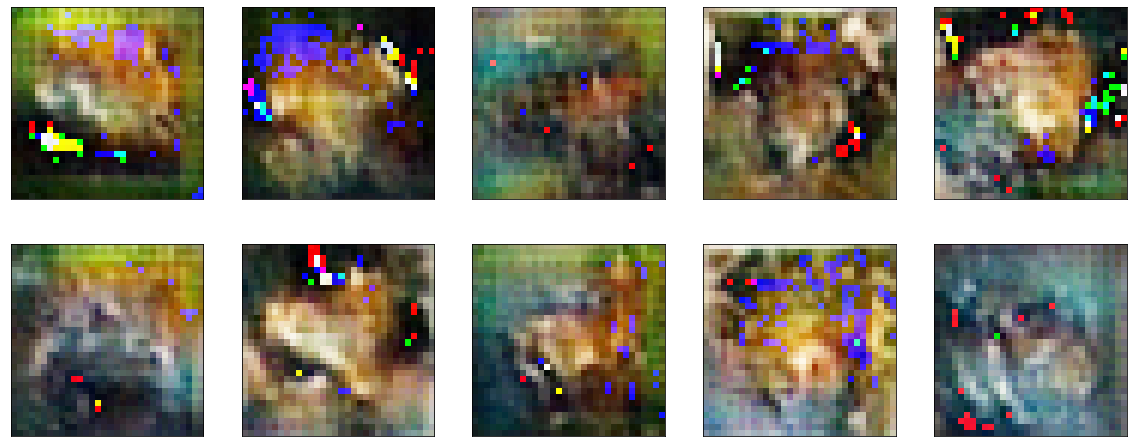

In [24]:
plt.figure(figsize=(20, 8))
for i in range(generated_images.shape[0]):
  plt.subplot(2, 5, i+1)
  img = image.array_to_img(generated_images[i] * 255., scale=False)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])

plt.show()